# Intraday Momentum Signals 

This notebook investigates whether there are profitable intraday momentum signals for cryptocurrency data at the 10s interval. 

In [21]:
%load_ext autoreload
%autoreload 2

import datetime as dt
from datetime import timedelta, datetime, date, time
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import time
import plotly.graph_objects as go 
import mplfinance as mpf
from scipy.stats import pearsonr

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Processing/Choice of Coin 

To start with, we will just look at Bitcoin. 

In [2]:
#Binance - BTC data - just use top-level bid/ask data for brevity 
raw_df = pd.read_parquet('data/btc_level1crypto_origin_times_resampled.parquet')

In [7]:
raw_df.isna().sum()

received_time    31267
bid_0_price      31267
ask_0_price      31267
bid_0_size       31267
ask_0_size       31267
symbol           31267
exchange         31267
dtype: int64

In [3]:
df = raw_df[['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size']].rename(columns={
    'bid_0_price': 'bid', 
    'ask_0_price': 'ask', 
    'bid_0_size': 'bid_size', 
    'ask_0_size': 'ask_size'
})
df['mid'] = (df['bid'] + df['ask'])/2

In [25]:
df.isna().sum()

bid         31267
ask         31267
bid_size    31267
ask_size    31267
mid         31267
dtype: int64

<Axes: xlabel='origin_time'>

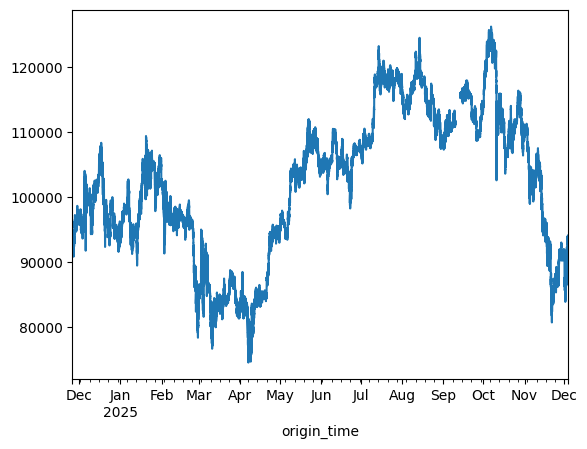

In [26]:
df['mid'].plot()

To avoid the problem of missing data we will simply restrict the training/test data to skip the September gap. 

In [28]:
train_df = df.loc[:'2025-09-01']

In [5]:
train_df.isna().sum()

bid         17
ask         17
bid_size    17
ask_size    17
mid         17
dtype: int64

In [29]:
train_df = df.loc[:'2025-09-01'].ffill()

<Axes: xlabel='origin_time'>

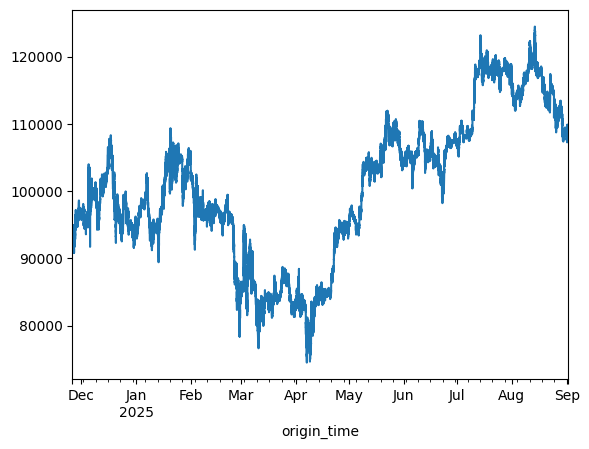

In [35]:
train_df['mid'].plot()

# Signal 1: Time Series Correlation 

Time series momentum means that past returns are positively correlated with future returns. One of the easiest ways to assess this is to calculate the correlation coefficient between lookback and holding period returns for a variety of windows. 

Note that the time tick unit is 10 seconds. 

In [17]:
from test_momentum import test_correlation

In [19]:
correlation_df = test_correlation(train_df['mid'], lookback = np.arange(1, 30), holding = np.arange(1,30)).sort_values(by = ['correlation'], ascending=False)
correlation_df

,lookback,holding,correlation,pvalue,n
0,1,1,0.046057,0.000000e+00,2419198
29,2,1,0.042678,0.000000e+00,1209599
494,18,2,0.040917,6.639204e-51,134399
1,1,2,0.039963,0.000000e+00,1209599
261,10,1,0.037463,7.218611e-76,241919
...,...,...,...,...,...
195,7,22,-0.034637,1.496791e-30,109963
734,26,10,-0.035228,6.006915e-27,93045
78,3,21,-0.037730,1.437540e-37,115199
114,4,28,-0.037745,1.274916e-28,86399


There is a question mark about the validity of the t-test for correlation, but the most important thing to note is that the correlation coefficients between lookback and holding are quite small and not likely to be profitable. 

#TODO - How? 

# Signal 2: Order book imbalances 

Most high-frequency momentum strategies involving extracting order book information. 

The most basic signal is exploiting instantaneous order book imbalances, for example if the bid size is bigger than the ask size, and vice versa. 

In [31]:
train_df['order_book_imbalance'] = (train_df['bid_size'] - train_df['ask_size']) / (train_df['bid_size'] + train_df['ask_size']) #Take as a ratio 

In [46]:
def calc_obi_corr(holding: list[int], df: pd.DataFrame): 
    results = {}
    for horizon in holding:
        #Calculate forward returns 
        fwd_ret = df['mid'].pct_change(horizon).shift(-horizon)
        # subsample every `horizon` steps to avoid overlapping forward return windows
        idx = range(0, len(df), horizon)
        obi = df['order_book_imbalance'].iloc[idx]
        fr = fwd_ret.iloc[idx]

        mask = obi.notna() & fr.notna()
        r, p = pearsonr(obi[mask], fr[mask])
        results[horizon] = {'correlation': r, 'pvalue': p, 'n': mask.sum()}
    
    final = pd.DataFrame(results).T
    final.index.name = 'holding_period'
    return final

In [47]:
HOLDING_PERIOD = [1, 3, 6, 18, 30, 60, 120, 300]
calc_obi_corr(holding = [1, 3, 6, 18, 30, 60, 120, 300], df = train_df)

,correlation,pvalue,n
holding_period,,,
1,0.188273,0.000000e+00,2419199.0
3,0.131122,0.000000e+00,806399.0
6,0.098187,0.000000e+00,403199.0
18,0.056291,9.239172e-95,134399.0
30,0.051026,1.226905e-47,80639.0
60,0.036742,1.585055e-13,40319.0
120,0.026695,1.502160e-04,20159.0
300,0.020070,7.152944e-02,8063.0


Correlation is higher than in purely time series momentum approach.

### Is the size of this correlation large enough to be profitable? 

#TODO 
Outside of a statistically significant result, it is not clear how "large" we need a correlation to be for a trading signal to be profitable. 

### Is the correlation stable over time? Some data visualisations. 

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_15901/890094078.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_df.groupby(pd.Grouper(freq='M'))


<Axes: title={'center': 'OBI vs Forward Return Correlation by Month'}, xlabel='origin_time'>

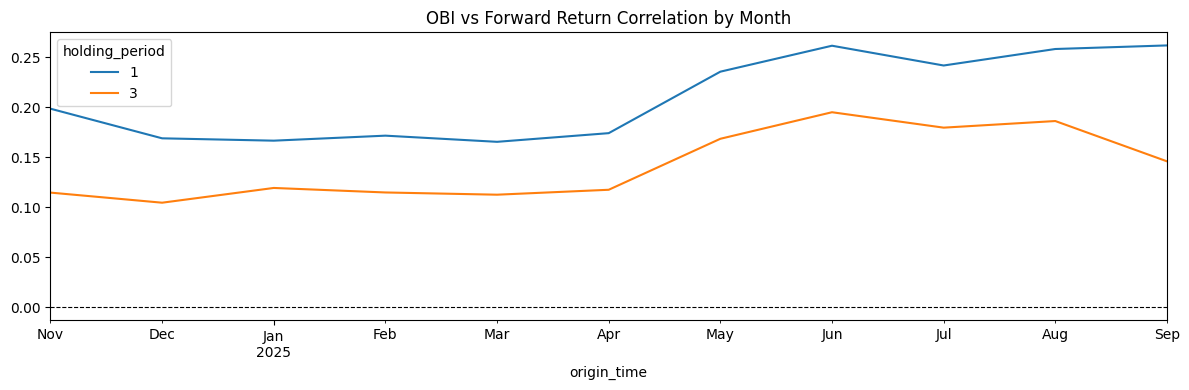

In [73]:
#Visualise by month 
corr_by_month = (
    train_df.groupby(pd.Grouper(freq='M'))
    .apply(lambda x: calc_obi_corr(holding=HOLDING_PERIOD, df=x).iloc[:2])
    .reset_index() 
).pivot(index = 'origin_time', columns = 'holding_period', values = 'correlation')

corr_by_month.plot(
    figsize=(12, 4),
    title='OBI vs Forward Return Correlation by Month'
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Rolling Correlation, Window = 1000: OBI vs 3-period Forward Returns')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Correlation')

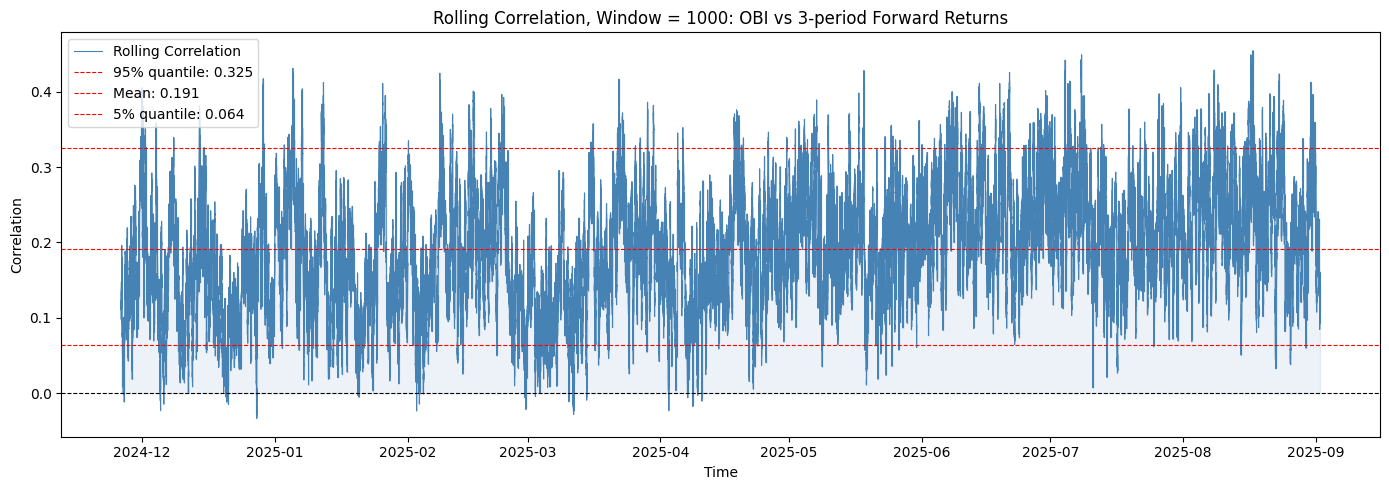

In [112]:
#Visualise/plot via rolling window approach 
ROLLING_WINDOW = 1000
roll_corr = train_df['order_book_imbalance'].rolling(ROLLING_WINDOW).corr(train_df['fwd_ret_3'])

plt.figure(figsize=(14, 5))
plt.plot(roll_corr, label='Rolling Correlation', color='steelblue', linewidth=0.8)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.axhline(y= roll_corr.quantile(0.95), color = 'red', linewidth = 0.8, linestyle = '--', label = f'95% quantile: {roll_corr.quantile(0.95):.3f}')
plt.axhline(y=roll_corr.mean(), color='red', linewidth=0.8, linestyle='--', label=f'Mean: {roll_corr.mean():.3f}')
plt.axhline(y= roll_corr.quantile(0.05), color = 'red', linewidth = 0.8, linestyle = '--', label = f'5% quantile: {roll_corr.quantile(0.05):.3f}')
plt.fill_between(roll_corr.index, roll_corr, 0, alpha=0.1, color='steelblue')
plt.title(f'Rolling Correlation, Window = {ROLLING_WINDOW}: OBI vs 3-period Forward Returns')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()

At a first glance, there is more oscillation in the rolling correlation than we might like. 

### Assessing p values - non parametric testing 

This is likely overkill due to the fact that CLT kicks in with large sample size. Furthermore, since we have chosen to avoid overlap between the pairs, the independence assumption behind the t-test is minimally violated. 

In addition, there is significant autocorrelation in the data but we are looking at comparatively short holding period returns - notice the correlation dies off the longer our holding period. So it's unclear what value a block permutation test would have. 

### Profitable/Tradeable?

#### Influence of fees 

The momementum is extremely short term, so there is a concern about whether or not fees might realistically wipe out any returns.

As a general first pass, I estimate the net returns less fees of various short term holding periods. At first glance the results appear discouraging, but in fact it's just not informative since it doesn't incorporate our order book imbalance signal. 

In [ ]:
#Calculate net returns after fees (from holding period )

net_returns_df= pd.DataFrame()
for horizon in [1, 3, 6, 18, 30, 60, 120, 300]:
    # Entry cost (pay 0.1% fee)
    entry_cost = train_df['mid'] * (1 + 0.001)
    # Exit proceeds (receive future price minus 0.1% fee)
    exit_proceeds = train_df['mid'].shift(-horizon) * (1 - 0.001)
    # Net return
    net_returns_df[f'net_ret_{horizon}'] = (exit_proceeds - entry_cost) / entry_cost

net_returns_df.mean()

net_ret_1     -0.001998
net_ret_3     -0.001998
net_ret_6     -0.001997
net_ret_18    -0.001996
net_ret_30    -0.001995
net_ret_60    -0.001992
net_ret_120   -0.001986
net_ret_300   -0.001970
dtype: float64

### Elementary Trading Strategy - Weighted by Imbalance 

To assess profitability, I implement an elementary/crude weighted strategy that goes long/short depending on magnitude of the order book imbalance, which is restricted to between -1 and 1. 

As a first pass, we allocate 100_000 USD initial capital based on the price of one BTC coin at the start of the training period. 

In [ ]:
#Base initial deployed 
train_df['mid'].iloc[0]

np.float64(92935.905)

In [205]:
TRADES_PER_YEAR = 365 * 24 * 3600 / 10  
FEE = 0.001  # 0.1% per side
CAPITAL = 100_000 
MAX_POSITION_FRAC = 1.0 #For simplicity 

results_df = {}
profit_df = {}

for horizon in [3, 6, 18, 30, 60, 120, 300, 600]:
    # subsample every horizon steps - non overlapping trades
    idx = range(0, len(train_df), horizon)
    obi = train_df['order_book_imbalance'].iloc[idx] 
    
    # entry and exit with fees
    entry_mid = train_df['mid'].iloc[idx] * (1 + FEE)
    exit_mid = train_df['mid'].shift(-horizon).iloc[idx] * (1 - FEE)
    
    # percentage return per trade - for sharpe ratio 
    total_deployed_capital = MAX_POSITION_FRAC * CAPITAL
    net_ret = (exit_mid - entry_mid) / entry_mid
    num_units = (total_deployed_capital / entry_mid) * obi
    pnl = num_units* net_ret
    
    # cash P&L - scaled to available deployed capital
    total_deployed_capital = MAX_POSITION_FRAC * CAPITAL
    pnl_cash = num_units * (exit_mid - entry_mid)
    cum_pnl= pnl_cash.cumsum()
    cum_pnl_pct = cum_pnl/CAPITAL
    
    # adjust trades per year for subsampling
    trades_per_year = 365 * 24 * 3600 / (10 * horizon)

    #drawdown 
    drawdown = (cum_pnl - cum_pnl.cummax()) / CAPITAL

    profit_df[horizon] = pd.DataFrame({
        'cum_pnl': cum_pnl, 
        'pnl_cash': pnl_cash,
        'cum_pnl_pct': cum_pnl_pct,
        'obi': obi, 
        'entry_mid': entry_mid,
        'exit_mid': exit_mid,
        'net_ret': net_ret, 
        'drawdown_pct': drawdown
    })
    results_df[horizon] = {
        'mean_return': pnl.mean(),
        'raw_sharpe': pnl.mean() / pnl.std(),
        'sharpe': pnl.mean() / pnl.std() * np.sqrt(trades_per_year),
        'std': pnl.std(),
        'win_rate': (pnl > 0).mean(),
        'sortino': (pnl[pnl>0].sum()) / (pnl[pnl<0].abs().sum()), 
        'max_drawdown_pct': drawdown.min(), 
    }

results_df = pd.DataFrame(results_df).T
profit_df = pd.concat(profit_df, axis=0)

In [206]:
results_df

,mean_return,raw_sharpe,sharpe,std,win_rate,sortino,max_drawdown_pct
3,0.000068,0.049226,50.470522,0.001386,0.511264,1.122708,-1.293667
6,0.000063,0.043850,31.790845,0.001437,0.508606,1.111138,-0.857604
18,0.000053,0.033324,13.948283,0.001587,0.506972,1.089419,-0.474080
30,0.000070,0.040578,13.156430,0.001724,0.509759,1.115466,-0.198086
60,0.000064,0.031535,7.229646,0.002027,0.507912,1.096272,-0.153762
120,0.000047,0.018582,3.012296,0.002529,0.504812,1.059947,-0.173790
300,0.000084,0.022936,2.351558,0.003652,0.515253,1.082286,-0.204962
600,0.000213,0.043142,3.127724,0.004937,0.522073,1.165020,-0.204836


In [197]:
profit_df

cum_pnl    pnl_cash  cum_pnl_pct       obi  \
  origin_time                                                            
3 2024-11-26 00:00:00 -4.073072e+01  -40.730718    -0.000407  0.750511   
  2024-11-26 00:00:30 -2.226631e+02 -181.932394    -0.002227  0.999393   
  2024-11-26 00:01:00 -3.067448e+02  -84.081680    -0.003067  0.249027   
  2024-11-26 00:01:30 -2.212326e+01  284.621534    -0.000221 -0.891059   
  2024-11-26 00:02:00  1.177978e+02  139.921030     0.001178 -0.748462   
...                             ...         ...          ...       ...   
  2025-09-01 23:57:30  5.565261e+06  -40.843678    55.652608  0.258929   
  2025-09-01 23:58:00  5.565079e+06 -182.234360    55.650786  0.875341   
  2025-09-01 23:58:30  5.564922e+06 -156.308617    55.649223  0.871602   
  2025-09-01 23:59:00  5.564970e+06   47.492078    55.649697 -0.233765   
  2025-09-01 23:59:30           NaN         NaN          NaN -0.681626   

                           entry_mid       exit_mid   net_ret  drawdown_pct  
  origin_time                                                                
3 2024-11-26 00:00:00   93028.840905   92978.353575 -0.000543      0.000000  
  2024-11-26 00:00:30   93164.496425   92994.897015 -0.001820     -0.001819  
  2024-11-26 00:01:00   93181.072985   92866.455585 -0.003376     -0.002660  
  2024-11-26 00:01:30   93052.374415   92755.147005 -0.003194      0.000000  
  2024-11-26 00:02:00   92940.842995   92767.095045 -0.001869      0.000000  
...                              ...            ...       ...           ...  
  2025-09-01 23:57:30  109307.192995  109134.770985 -0.001577     -0.081425  
  2025-09-01 23:58:00  109353.259015  109125.600165 -0.002082     -0.083247  
  2025-09-01 23:58:30  109344.069835  109147.977765 -0.001793     -0.084810  
  2025-09-01 23:59:00  109366.492235  109144.301445 -0.002032     -0.084336  
  2025-09-01 23:59:30  109362.808555            NaN       NaN           NaN  

[806400 rows x 8 columns]

array([<Axes: xlabel='origin_time'>, <Axes: xlabel='origin_time'>,
       <Axes: xlabel='origin_time'>], dtype=object)

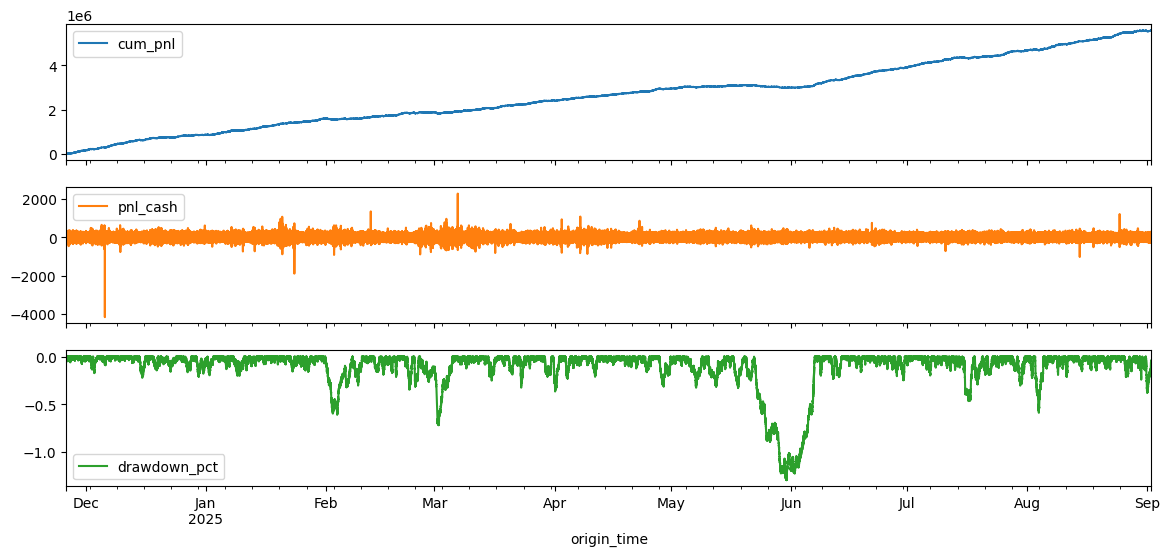

In [198]:
profit_df.loc[3][['cum_pnl', 'pnl_cash', 'drawdown_pct']].plot(subplots=True, figsize = (14, 6))

<Axes: xlabel='origin_time'>

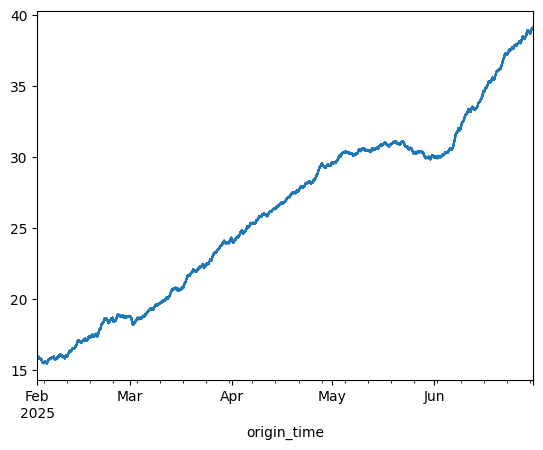

In [202]:
profit_df.loc[3]['cum_pnl_pct'].loc['2025-02': '2025-06'].plot()

These results seem quite suspicious. 
- Sharpe ratio very high, seems artificial, and Sortino is extremely low - why? 
  - Why is the Sharpe so high? 
- Win rate of only around 50% 
- Max drawdowns are quite alarming - why do they occur, and why does it lessen as we increase the holdout period? 

In [166]:
### Comparison to benchmark strategy 

long_only_sharpe = (train_df['net_ret_3'].mean()/train_df['net_ret_3'].std())
obi_sharpe = results_df.loc[3]['raw_sharpe']

print(f"Long only: {long_only_sharpe:.6f}")
print(f"OBI strategy: {obi_sharpe:.6f}")
print(f"OBI edge: {obi_sharpe - long_only_sharpe:.6f}")

Long only: -4.384074
OBI strategy: 0.050769
OBI edge: 4.434843


### Conclusion 

Trading based on order book imbalances and holding for short timeframes (e.g. 3 or 6 periods ~ 30 or 60 seconds each) has raw/not annualised sharpe ratio that beats a baseline long only strategy. However, the maximum drawdown is massive. There is a question mark of why this is occuring and also why the problem seems to lessen as we increase the timeframe for holding. The tradeoff is that the correlation between instantaneous order book imbalance and longer term returns is not as strong. 

### Further Areas To Understand 
- Is Sharpe ratio artificially inflated due to the frequency of the trades? 
- Influence of the win rate - does this matter at all? 
- Max drawdown - why is it occuring? A period of sudden and extreme loss. 
- How much correlation do we need? 


## Signal 3 - Other applicable HFT strategies

There are a few other trading strategies mentioned in Ernie P Chan's "Trading Strategies & Their Rationale". 

- Ratio Trade (**for pro-rata markets**)
  - Pro-rata markets fill orders proportionally rather than on a first-come first served basis, so if we join a top-level bid/ask we are guaranteed to get a partial fill 
  - Strategy: if bid size >> ask size, place a limit buy order at the BID price 
    - Case 1: Buying pressure pushes up both bid and ask prices, then either: 
      - Hit the higher bid price 
      - Place sell order at ask price 
    - Case 2: Buying pressure does not materalise, then will likely stil be able to resell at the original bid price with loss of commissions only 

- Quote matching
  - If the bid-ask spread is sufficiently wide (e.g. > 2 ticks), then front-run it by posting a higher bid price (then the best bid) and try to sell at a price lower than lowest ask price 
  
- Momentum ignition (market manipulation)
  - Suppose that bid/ask spread is very small 
  - Place a large buy limit order at the best bid to create impression of buying pressure 
  - Simultaneously, place a small sell limit order at the best ask 
  - Trick traders into buying at the ask price since they anticipate an uptick 
  - Cancel large buy order 
  - Best bid/ask sizes are now equal again 

## Signal 4 - Order Flow Information
- Use order flow to predict 